In [1]:
import os
import scvi
import scgen
import rpy2
import scib
import json
import torch
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
import doubletdetection
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from scipy.sparse import csr_matrix
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` name

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
adjustText                  NA
anndata2ri                  1.1
annoy                       NA
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy    

In [4]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(Seurat)
    library(tibble)
    library(magrittr) # needs to be run every time you start R and want to use %>%
})



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

##### Load DEGs from Cell-type Differential Expression with Wilcoxon Rank-Sum and Mixed-Model Tests

In [5]:
cell_types = ['Excitatory', 'Inhibitory', 'Oligodendrocyte', 'Astrocyte', 'Microglia', 'OPC', 'Endothelial']

degs_t_test = {}
mast_degs = {}

for cell_type in cell_types:

    degs_t_test[cell_type] = pd.read_excel('../results/ad_vs_no/t_test_degs.xlsx', 
                                   sheet_name=cell_type)
    mast_degs[cell_type] = pd.read_excel("../results/ad_vs_no/mixed_model_degs.xlsx", 
                                   sheet_name=cell_type)


Reported DEGs

Next, we load the reported DEGs from [**Hansruedi Mathys et. al.**](https://doi.org/10.1038/s41586-019-1195-2) for comparison in a later step

In [6]:
mathys_degs = {}
for key in cell_types:
    try:
        mathys_degs[key] = pd.read_excel(f'../data/raw/mathys_pfc_from_paper/degs/ad_vs_no/{key.lower()}_degs.xlsx')
        mathys_degs[key].rename({'Unnamed: 0': 'names'}, inplace=True)
        mathys_degs[key]['IndModel.absFC'] = np.abs(mathys_degs[key]['IndModel.FC'])

    except FileNotFoundError:
        continue

## Volcano Plot

In [7]:
def volcano_plot(df: pd.DataFrame, gene_col_name: str='names', p_vals_col_name:str= 'pvals_adj',
                lfc_col_name:str= 'logfoldchanges', lfc_thresh = 0.5, pval_thresh=0.01, 
                figure_name='volcano_plot_mathys_degs_recalc',  savefig=True, output_path="../results/",
                genes_to_label = [], n_genes_to_label:int=20, log10p=True):

    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    # Create some fake data
    pvals = df[p_vals_col_name]
    log_fc = df[lfc_col_name]

    down_genes = df[df[lfc_col_name]<0].reset_index().loc[:n_genes_to_label, [gene_col_name, lfc_col_name, p_vals_col_name]].values
    up_genes = df[df[lfc_col_name]>0].reset_index().loc[:n_genes_to_label, [gene_col_name, lfc_col_name, p_vals_col_name]].values


    # Calculate the negative log of the p-values in base 10
    if log10p:
        neg_log_pvals = -np.log10(pvals)


    # Generate the volcano plot
    fig, ax = plt.subplots(figsize=(5, 5))
    font = {'family': 'serif', 'color': 'black', 'size': 11}

    ax.scatter(log_fc[df[lfc_col_name]<0], neg_log_pvals[df[lfc_col_name]<0], s=0.5, c='k', marker=matplotlib.markers.CARETDOWNBASE)
    ax.scatter(log_fc[df[lfc_col_name]>0], neg_log_pvals[df[lfc_col_name]>0], s=0.5, c='k', marker=matplotlib.markers.CARETUPBASE)

    # Annotate the points with gene names
    for val in up_genes:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='blue', fontsize=5)

    for val in down_genes:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='red', fontsize=5)


    ax.set_xlabel('log fold change', fontdict=font)
    ax.set_ylabel('-log(adjusted P value)', fontdict=font)
    ax.set_title('Volcano plot', fontdict=font)

    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    ax.tick_params(width=0.5)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axvline(x = -lfc_thresh, color = 'r', linewidth=0.5)
    plt.axvline(x = lfc_thresh, color = 'r', linewidth=0.5)
    plt.axhline(y = -np.log10(pval_thresh), color = 'r', linewidth=0.5)
    plt.xlim(-7.5, 7.5)
    
    if savefig:
        plt.savefig(output_path + figure_name + '.pdf')

    plt.show(block=False)


#### **For Published Data**

Excitatory


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3707/374364238.py:33: RuntimeWarning: divide by zero encountered in log10
  ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3707/374364238.py:39: RuntimeWarning: divide by zero encountered in log10
  ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),


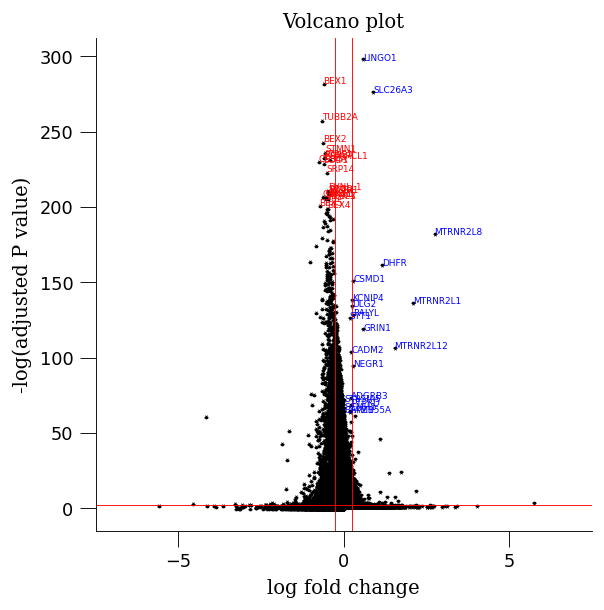

Inhibitory


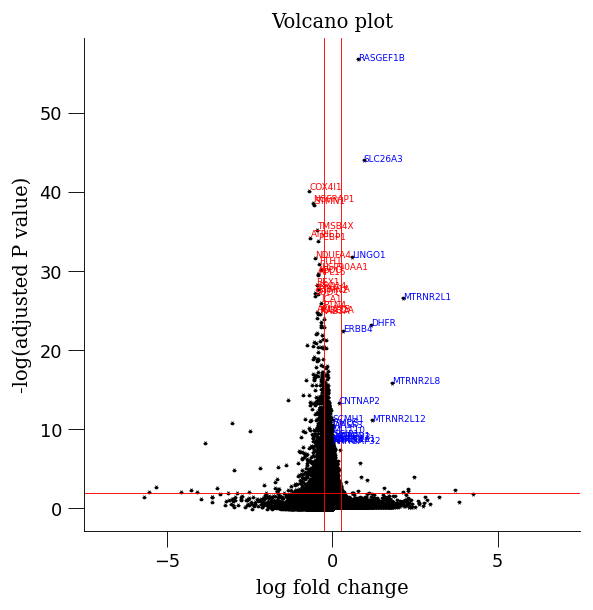

Oligodendrocyte


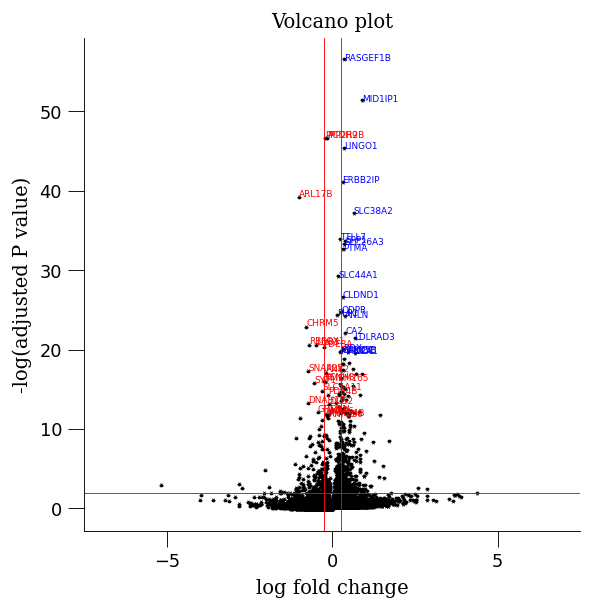

Astrocyte


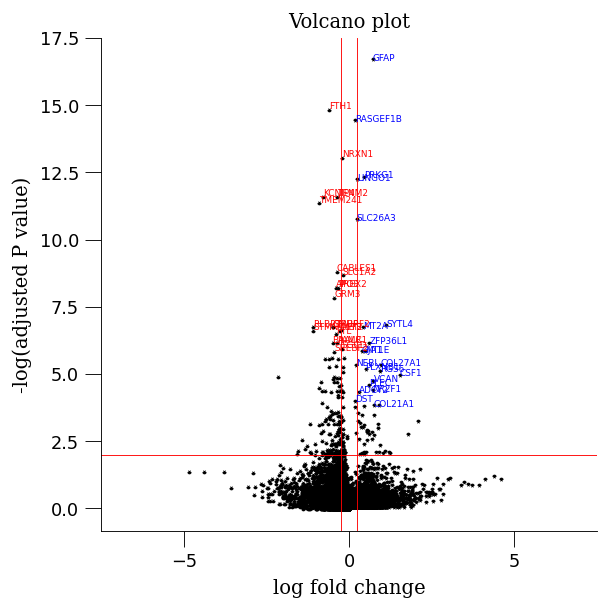

Microglia


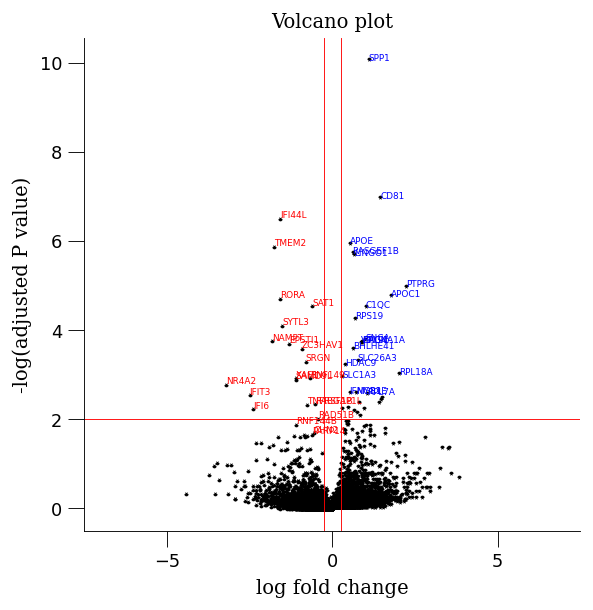

OPC


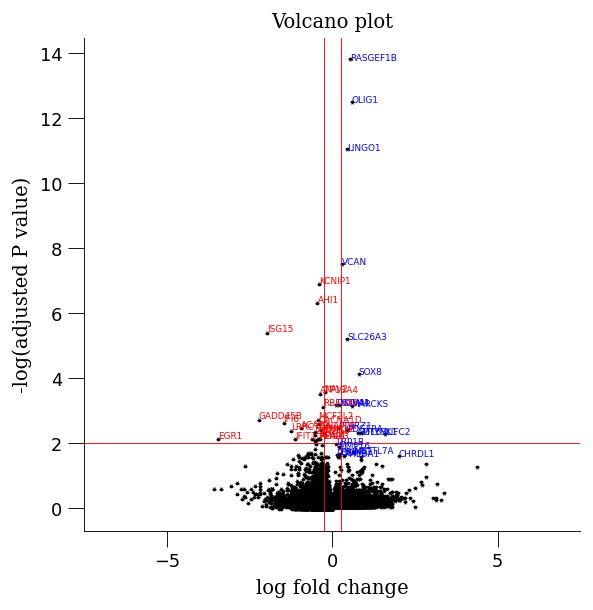

In [8]:
for key in mathys_degs.keys():
    print(key)
    volcano_plot(mathys_degs[key], gene_col_name='Unnamed: 0', p_vals_col_name= 'IndModel.adj.pvals',
                lfc_col_name='IndModel.FC', lfc_thresh = 0.25, pval_thresh=0.01, 
                figure_name=f'{key}_volcano_plot_mathys_degs_from_paper',  
                savefig=False, output_path="../results/ad_vs_no/volcano_plots_from_paper/",
                n_genes_to_label=20, log10p=True)


#### **For recalculated**

Excitatory


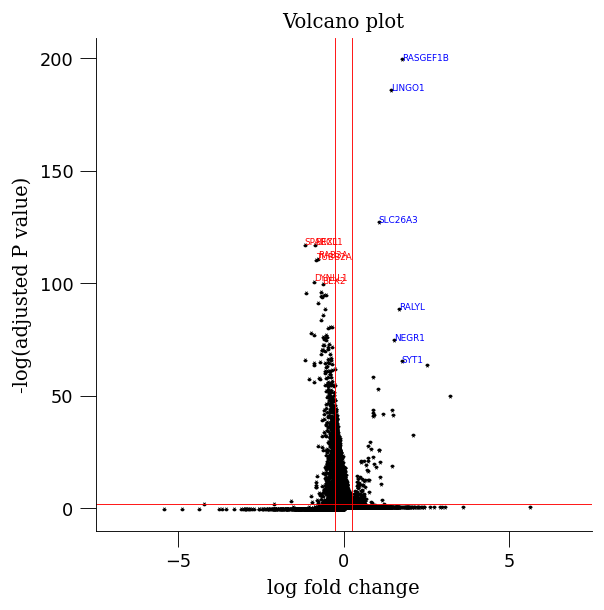

Inhibitory


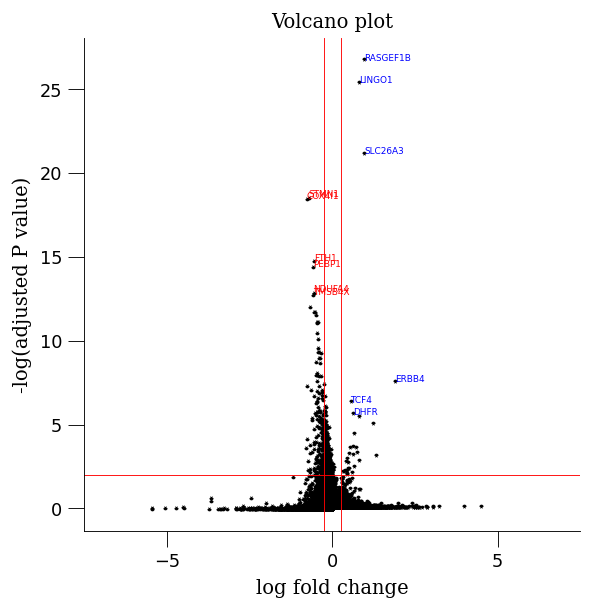

Oligodendrocyte


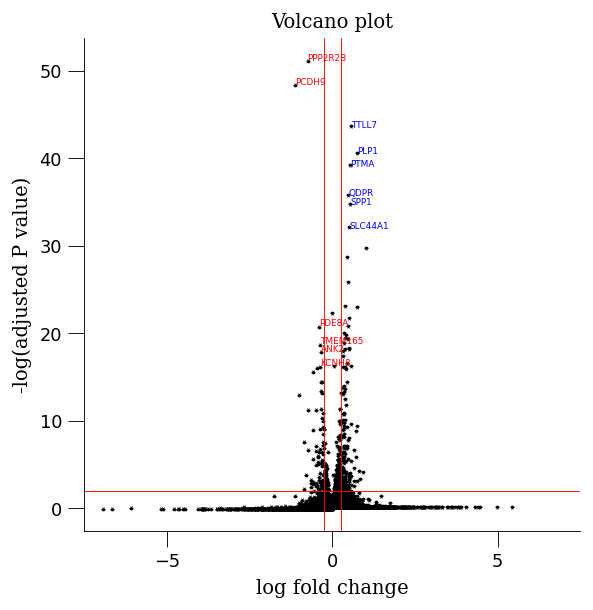

Astrocyte


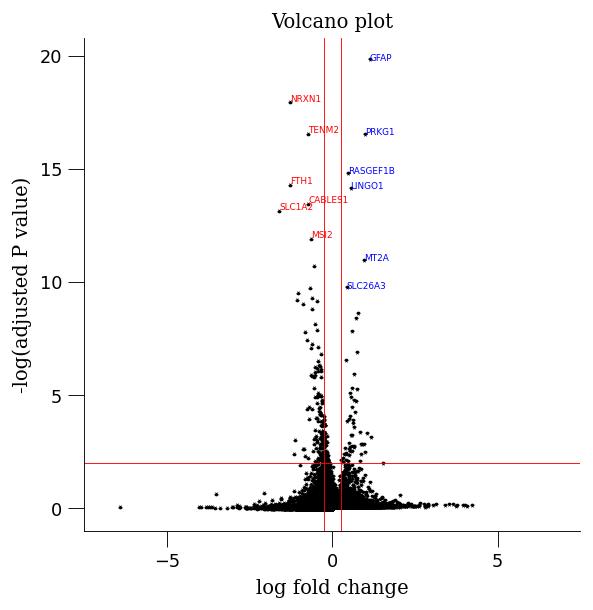

Microglia


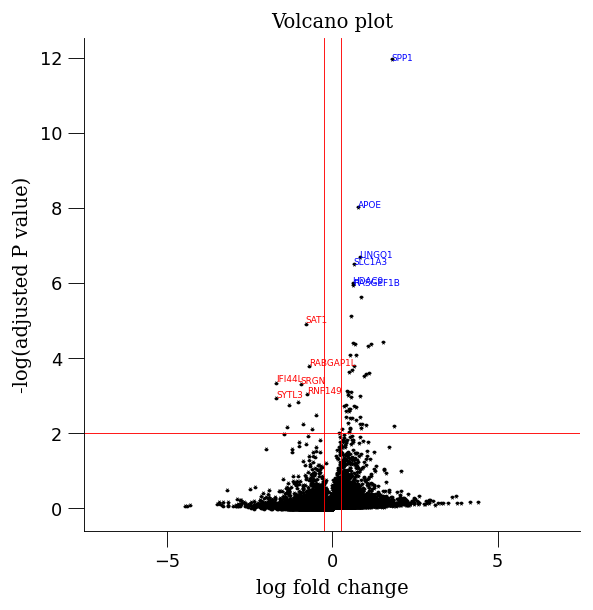

OPC


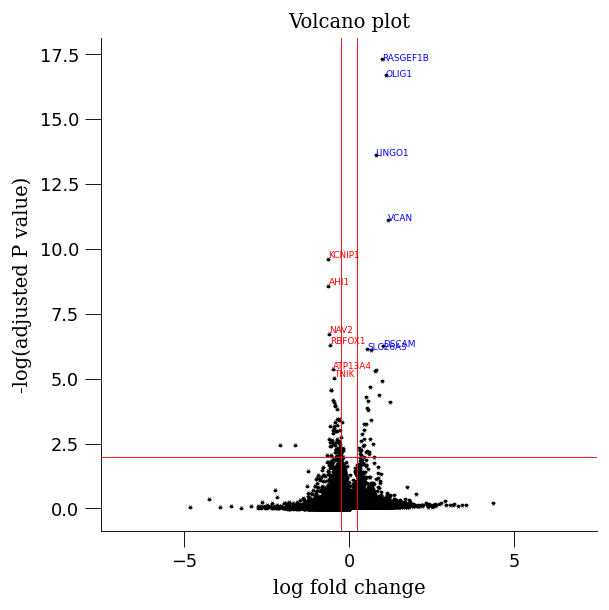

Endothelial


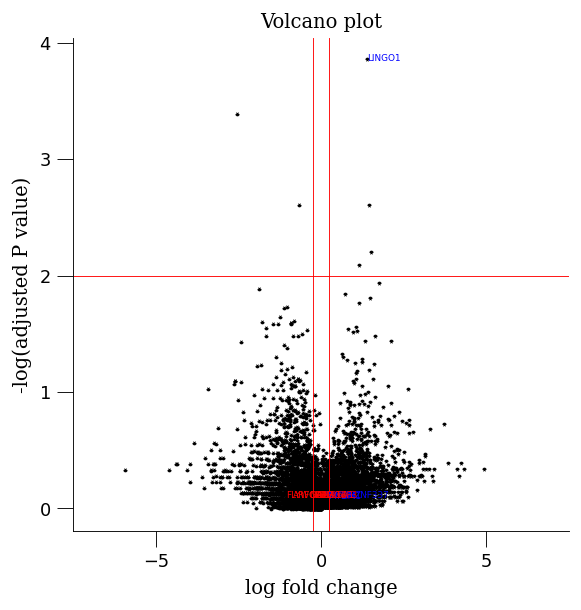

In [10]:
for key in mast_degs.keys():
    print(f'{key}')
    #df = mast_overlap[key][mast_overlap[key].names.isin(csp_genes.Symbol)]
    df = mast_degs[key]
    volcano_plot(df, gene_col_name='names', p_vals_col_name= 'pvals',
                lfc_col_name='logfoldchanges', lfc_thresh = 0.25, pval_thresh=0.01, 
                figure_name=f'{key}_volcano_plot_mathys_degs_recalculated_mathys',  
                savefig=True, output_path="../results/ad_vs_no/volcano_plots/",
                n_genes_to_label=5, log10p=True)

In [11]:
def volcano_plot_double(df1: pd.DataFrame, df2: pd.DataFrame, 
                        gene_col_name1: str='names', gene_col_name2: str='Unnamed: 0', 
                        p_vals_col_name1:str= 'pvals_adj', p_vals_col_name2:str= 'IndModel.adj.pvals',
                        lfc_col_name1:str= 'logfoldchanges', lfc_col_name2:str= 'IndModel.FC', 
                        lfc_thresh = 0.5, pval_thresh=0.01, 
                        figure_name='volcano_plot_mathys_degs_ori_n_V7',  savefig=True, output_path="../results/",
                        genes_to_label = [], n_genes_to_label:int=5, log10p=True):

    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    # Create some fake data
    # pvals1 = df1[p_vals_col_name1]
    # log_fc1 = df1[lfc_col_name1]

    # pvals2 = df2[p_vals_col_name2]
    # log_fc2 = df2[lfc_col_name2]

    down_genes2 = df2[df2[lfc_col_name2]<0].reset_index().loc[:n_genes_to_label, [gene_col_name2, lfc_col_name2, p_vals_col_name2]].values
    up_genes2 = df2[df2[lfc_col_name2]>0].reset_index().loc[:n_genes_to_label, [gene_col_name2, lfc_col_name2, p_vals_col_name2]].values
    all_genes2 = [g[0] for g in up_genes2] + [g[0] for g in down_genes2]
    pvals2 = [p[2] for p in up_genes2] + [p[2] for p in down_genes2]
    log_fc2 = [l[1] for l in up_genes2] + [l[1] for l in down_genes2]

    down_genes1 = df1[(df1[gene_col_name1].isin(all_genes2)) & (df1[lfc_col_name1]<0)][[gene_col_name1, lfc_col_name1, p_vals_col_name1]].values 
    up_genes1 = df1[(df1[gene_col_name1].isin(all_genes2)) & (df1[lfc_col_name1]>0)][[gene_col_name1, lfc_col_name1, p_vals_col_name1]].values
    pvals1 = [p[2] for p in up_genes1] + [p[2] for p in down_genes1]
    log_fc1 = [l[1] for l in up_genes1] + [l[1] for l in down_genes1]

    # Calculate the negative log of the p-values in base 10
    if log10p:
        neg_log_pvals1 = -np.log10(pvals1)
        neg_log_pvals2 = -np.log10(pvals2)


    # Generate the volcano plot
    fig, ax = plt.subplots(figsize=(5, 5))
    font = {'family': 'serif', 'color': 'black', 'size': 11}

    p1 = ax.scatter(log_fc1, neg_log_pvals1, s=0.5, c='k', label='Version 7', marker=matplotlib.markers.CARETDOWNBASE)
    p2 = ax.scatter(log_fc2, neg_log_pvals2, s=0.5, c='b', label='Original', marker=matplotlib.markers.CARETUPBASE)

    # ax.scatter(up_genes1[1], -np.log10(up_genes1[2]), s=0.5, c='b', marker=matplotlib.markers.CARETUPBASE)
    # ax.scatter(up_genes2[1], -np.log10(up_genes2[2]), s=0.5, c='k', marker=matplotlib.markers.CARETUPBASE)

    # ax.scatter(down_genes1[1], -np.log10(down_genes1[2]), s=0.5, c='b', marker=matplotlib.markers.CARETUPBASE)
    # ax.scatter(down_genes2[1], -np.log10(down_genes2[2]), s=0.5, c='k', marker=matplotlib.markers.CARETUPBASE)

    # Annotate the points with gene names
    for val in up_genes1:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='black', fontsize=5)

    for val in down_genes1:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='black', fontsize=5)



    # Annotate the points with gene names
    for val in up_genes2:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='blue', fontsize=5)

    for val in down_genes2:
        x_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        y_offset = (0.7 - 0.2) * np.random.random_sample() + 0.2
        ax.annotate(val[0], xy=(val[1], -np.log10(val[2])), xytext=(val[1], -np.log10(val[2])),
                    color='blue', fontsize=5)



    ax.set_xlabel('log fold change', fontdict=font)
    ax.set_ylabel('-log(adjusted P value)', fontdict=font)
    ax.set_title('Volcano plot', fontdict=font)

    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    ax.tick_params(width=0.5)
    ax.legend([p1, p2], ['Version 7', 'Original'], fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axvline(x = -lfc_thresh, color = 'r', linewidth=0.5)
    plt.axvline(x = lfc_thresh, color = 'r', linewidth=0.5)
    plt.axhline(y = -np.log10(pval_thresh), color = 'r', linewidth=0.5)

    
    if savefig:
        plt.savefig(output_path + figure_name + '.pdf')

    plt.show()

In [12]:
# for key in mathys_degs.keys():
#     print(key)

#     volcano_plot_double(mast_overlap[key], mathys_degs[key], 
#                 gene_col_name1='names', gene_col_name2='Unnamed: 0', 
#                 p_vals_col_name1='pvals_adj', p_vals_col_name2= 'IndModel.adj.pvals',
#                 lfc_col_name1='logfoldchanges', lfc_col_name2='IndModel.FC',
#                 lfc_thresh = 0.25, pval_thresh=0.05, 
#                 figure_name=f'{key}_volcano_plot_mathys_degs_ori_n_V7',  
#                 savefig=True, output_path="../results/",
#                 n_genes_to_label=5, log10p=True)

### Generate Figure 1

In [13]:
deg_list = ["DHFR", "MT2A", "RASGEF1B", "LINGO1", "MTRNR2L8", "GFAP", "COX4l1", "TUBB2A", "STMN1", "SOD1", "RAB3A", "CIRBP", "CES4A", 
           "TMEM241", "ICA1", "BEX1", "BEX3", "NDUFA4", "STMN2", "CABLES1", "PREX2", "GRM3", "KCNIP4", "RLBP1", "SMURF2", "SLC38A2",
            "SPP1", "PTMA", "CLDND1", "QDPR", "ANLN", "CA2", "LDB3", "OLIG1", "VCAN", "SOX8", "KCNIP1", "AHI1", "ATP13A4", "MCF2L2",
            "GADD45B", "CACNA1D", "CD81", "APOE", "PTPRG", "APOC1", "SNCA", "C1QC", "RPS19", "SYTL3", "RORA",]

mast_data = pd.DataFrame(columns=['names'])
mast_data.names = mast_degs['Excitatory'].names.sort_values().copy()

mathys_data = pd.DataFrame(columns=['names'])
mathys_data.names = mathys_degs['Excitatory']['Unnamed: 0'].sort_values().copy()

for key in mathys_degs.keys():
    mathys_data[key] = None
    mast_data[key] = None
    #mast_data[key] = mast_overlap[key].sort_values(by='names')['scores']
    mast_data[key] = mast_data['names'].apply(lambda x: mast_degs[key].loc[mast_degs[key]['names']==x,
                                             'scores'].values).apply(lambda x: x[0] if len(x)>0 and x!=[np.nan] else np.nan)

    mathys_data[key] = mathys_data['names'].apply(lambda x: mathys_degs[key].loc[mathys_degs[key]['Unnamed: 0']==x,
                                                 'MixedModel.z'].values).apply(lambda x: x[0] if len(x)>0 and x!=[np.nan] else np.nan)

mast_data.set_index('names', inplace=True)
mast_data = mast_data[mast_data.index.isin(deg_list)]
mast_data = mast_data.reindex(deg_list)
mast_data = mast_data[['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']]

mathys_data.set_index('names', inplace=True)
mathys_data = mathys_data[mathys_data.index.isin(deg_list)]
mathys_data = mathys_data.reindex(deg_list)
mathys_data = mathys_data[['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']]

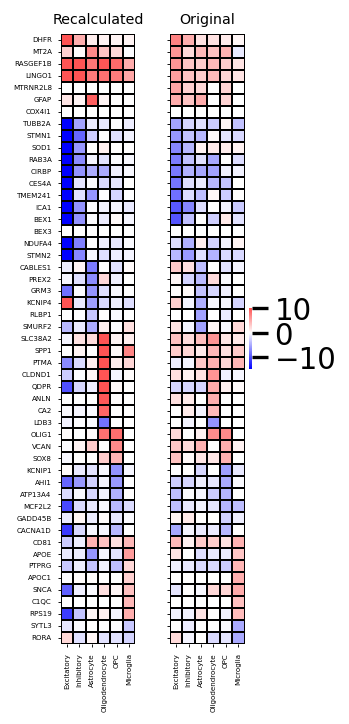

<Figure size 819.2x614.4 with 0 Axes>

In [14]:
xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']

#$fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6, 12))
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[0.8,1]}, sharey=True, figsize=(3, 6))

g1 = sb.heatmap(mast_data, vmin=-15, vmax=10, cmap='bwr', center=0, 
           robust=False, annot=None, fmt='.1g', annot_kws=None, linewidths=0.15, linecolor='black',
           cbar=False, cbar_kws={'shrink': 0.1}, cbar_ax=None, square=False, xticklabels=xticks,
           yticklabels=deg_list, mask=None, ax=ax1)

g1.set_title('Recalculated', fontsize=8)           
g1.set_ylabel('')
g1.set_xlabel('')


g2 = sb.heatmap(mathys_data, vmin=-15, vmax=10, cmap='bwr', center=0, 
           robust=False, annot=None, fmt='.1g', annot_kws=None, linewidths=0.15, linecolor='black',
           cbar=True, cbar_kws={'shrink': 0.1,}, cbar_ax=None, square=False, xticklabels=xticks,
           yticklabels=deg_list, mask=None, ax=ax2)

g2.set_title('Original', fontsize=8)   
g2.set_ylabel('')
g2.set_xlabel('')

ax1.tick_params(axis='both', which='major', labelsize=4, length=1.5, width=0.5)
ax2.tick_params(axis='both', which='major', labelsize=4, length=1.5, width=0.5)

plt.tight_layout()
plt.show(block=False)
plt.savefig('../results/ad_vs_no/top_DEGs_differential_scores.pdf')